<center><img src='../img/scientific_model_selection.jpg' alt='Model Selection' height='300'/></center>

# Classification Models: Heart Disease

## Introduction

In this notebook, we will use the outcomes from [nb01_exploratory_analysis.ipynb](./nb01_exploratory_analysis.ipynb), where we explored the **classification problem of predicting heart attacks** using the [Behavioral Risk Factor Surveillance System](https://www.cdc.gov/brfss/annual_data/annual_2022.html) dataset. We compared different feature sets by evaluating models based on recall and execution time.

As discussed in the previous analysis, the primary goal is to minimize false negatives by **optimizing the recall metric**, which is critical in medical applications where missing a heart attack diagnosis could have severe consequences.

## Feature Selection

We also introduced various feature selection techniques, including Recursive Feature Elimination with Cross-Validation (RFECV) with expert knowledge provided by the cardiologist [María Davó Jiménez](https://www.linkedin.com/in/mar%C3%ADa-dav%C3%B3-jim%C3%A9nez-b63371233/) from [Northwestern University](https://www.northwestern.edu/) (Chicago, IL). The outcomes from these feature sets showed promising recall performance, without excesibe computational cost.

## Model Selection

In this notebook, we will continue our work by diving deeper into the model performance with the selected feature set. We will explore how they contribute to enhancing recall while maintaining computational efficiency, ensuring that **we prioritize the identification of high-risk heart attack cases**.


## Libraries

In [1]:
import os
import pickle
import sys
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, roc_auc_score)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score, train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, OrdinalEncoder,
                                   PowerTransformer)
from sklearn.svm import SVC
from xgboost import XGBClassifier

# add "src" path
root_path = os.path.abspath(os.path.join(os.getcwd(), '..')) 
if os.path.exists(root_path) and root_path not in sys.path: 
    sys.path.append(root_path)

from utils.datascience import get_cardinality

# modern style
sns.set_theme(style='dark', palette='bright')

# pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None) 

## Load dataset and train-validation-test split

We previously stored the "train" and "test" sets in .CSV files, so now we can load them.

In [ ]:
# for reproducibility
random_state = 42

# load dataset and train-validation-test split
train_val_set = pd.read_csv('../data/processed/heart_disease_train.csv')
train_set, val_set = train_test_split(train_val_set, 
                                      test_size=0.2, 
                                      stratify=train_val_set['HadHeartAttack'], 
                                      random_state=random_state)
test_set = pd.read_csv('../data/processed/heart_disease_test.csv')


In [3]:
# sets shape (64-16-20 approximately)
print(train_set.shape)
print(val_set.shape)
print(test_set.shape)


(157453, 40)
(39364, 40)
(49205, 40)


In [4]:
# dataset head
train_val_set.head(5)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Ohio,Male,Fair,0.0,0.0,Within past year (anytime less than 12 months ago),No,8.0,None of them,No,Yes,No,No,Yes,No,No,No,No,Yes,No,No,No,Yes,No,No,Former smoker,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 80 or older,1.78,65.77,20.81,No,No,Yes,Yes,"No, did not receive any tetanus shot in the past 10 years",No,No
1,Oklahoma,Female,Good,0.0,0.0,Within past year (anytime less than 12 months ago),No,6.0,"6 or more, but not all",No,No,No,Yes,No,Yes,No,No,Yes,No,No,No,No,No,No,No,Former smoker,Use them some days,Yes,"Multiracial, Non-Hispanic",Age 60 to 64,1.70,63.50,21.93,No,No,No,Yes,"Yes, received Tdap",No,No
2,Alabama,Male,Good,10.0,5.0,Within past 2 years (1 year but less than 2 years ago),Yes,6.0,1 to 5,Yes,No,No,No,Yes,No,Yes,No,Yes,No,No,No,Yes,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 60 to 64,1.65,65.77,24.13,No,No,Yes,Yes,"Yes, received Tdap",No,Yes
3,New Jersey,Male,Good,0.0,5.0,Within past year (anytime less than 12 months ago),Yes,7.0,1 to 5,No,No,No,No,No,No,Yes,No,Yes,No,Yes,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 75 to 79,1.70,104.33,36.02,Yes,No,Yes,Yes,"Yes, received Tdap",No,No
4,California,Male,Good,5.0,0.0,Within past year (anytime less than 12 months ago),Yes,8.0,1 to 5,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 65 to 69,1.75,83.91,27.32,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,Yes


In [5]:
# cardinality info
get_cardinality(train_set)

pandas.DataFrame shape: (157453, 40)


,Card,%_Card,NaN_Values,%_NaN_Values,Type,Class
State,54,0.034296,0,0.0,object,Numeric - Discrete
Sex,2,0.00127,0,0.0,object,Binary
GeneralHealth,5,0.003176,0,0.0,object,Categoric
PhysicalHealthDays,31,0.019688,0,0.0,float64,Numeric - Discrete
MentalHealthDays,31,0.019688,0,0.0,float64,Numeric - Discrete
LastCheckupTime,4,0.00254,0,0.0,object,Categoric
PhysicalActivities,2,0.00127,0,0.0,object,Binary
SleepHours,23,0.014608,0,0.0,float64,Numeric - Discrete
RemovedTeeth,4,0.00254,0,0.0,object,Categoric
HadHeartAttack,2,0.00127,0,0.0,object,Binary


In [6]:
# target distribution
train_set['HadHeartAttack'].value_counts(normalize=False)

HadHeartAttack
No     148855
Yes      8598
Name: count, dtype: int64

Remember that the target variable, **HadHeartAttack, is highly imbalanced** in this dataset. However, the dataset contains a substantial number of entries, which gives us the opportunity to implement **undersampling** techniques. This approach would help to balance the classes while still maintaining enough data for effective model training and evaluation.

## Feature Selection

The selected features were chosen through RFECV and by a cardiologist-expert, as explained in [nb01_exploratory_analysis.ipynb](./nb01_exploratory_analysis.ipynb).


In [7]:
# classification target
TARGET = 'HadHeartAttack'

# ordinal features
ORD_FEATURES = [
    'GeneralHealth',
    'RemovedTeeth',
    'HadDiabetes', 
    'SmokerStatus',
    'AgeCategory'
]

# binary features
BINARY_FEATURES = [
    'HadAngina',
    'HadStroke',
    'HadCOPD',
    'DeafOrHardOfHearing',
    'DifficultyWalking',
    'ChestScan',   
    'AlcoholDrinkers',
    'Sex',  
    'PhysicalActivities'
]

# numerical features
NUM_FEATURES = [    
    'SleepHours',
    'WeightInKilograms',
    'BMI'
]

# features selected by RFECV and cardiologist expertise
FEATURES = ORD_FEATURES + BINARY_FEATURES + NUM_FEATURES

In [8]:
# cardinality info
get_cardinality(train_set[FEATURES])

pandas.DataFrame shape: (157453, 17)


,Card,%_Card,NaN_Values,%_NaN_Values,Type,Class
GeneralHealth,5,0.003176,0,0.0,object,Categoric
RemovedTeeth,4,0.00254,0,0.0,object,Categoric
HadDiabetes,4,0.00254,0,0.0,object,Categoric
SmokerStatus,4,0.00254,0,0.0,object,Categoric
AgeCategory,13,0.008256,0,0.0,object,Numeric - Discrete
HadAngina,2,0.00127,0,0.0,object,Binary
HadStroke,2,0.00127,0,0.0,object,Binary
HadCOPD,2,0.00127,0,0.0,object,Binary
DeafOrHardOfHearing,2,0.00127,0,0.0,object,Binary
DifficultyWalking,2,0.00127,0,0.0,object,Binary


In [9]:
# ordered list for the ordinal encoders (from "bad" to "good")
GEN_HEALTH = [
    'Poor',
    'Fair', 
    'Good', 
    'Very good', 
    'Excellent'
]

REMOVED_TEETH = [
    'All',
    '6 or more, but not all',
    '1 to 5',
    'None of them'
]

DIABETES = [
    'Yes',
    'Yes, but only during pregnancy (female)',
    'No, pre-diabetes or borderline diabetes',
    'No'    
]

SMOKER_STATUS = [
    'Current smoker - now smokes every day',
    'Current smoker - now smokes some days',
    'Former smoker',
    'Never smoked'
]

# from younger to older
AGE_CATEGORY = [
    'Age 18 to 24', 
    'Age 25 to 29', 
    'Age 30 to 34', 
    'Age 35 to 39', 
    'Age 40 to 44', 
    'Age 45 to 49', 
    'Age 50 to 54', 
    'Age 55 to 59', 
    'Age 60 to 64', 
    'Age 65 to 69', 
    'Age 70 to 74', 
    'Age 75 to 79', 
    'Age 80 or older'
]


## X, y split and target encoder

In [10]:
# X, y splits
X_train = train_set.drop(columns=[TARGET])
y_train = train_set[TARGET]

X_val = val_set.drop(columns=[TARGET])
y_val = val_set[TARGET]

X_test = test_set.drop(columns=[TARGET])
y_test = test_set[TARGET]

In [11]:
# unique values y_train
y_train.value_counts()


HadHeartAttack
No     148855
Yes      8598
Name: count, dtype: int64

In order to integrate the datasets on multiple models, we will use a LabelEncoder. This is particularly useful in this project because it sorts the labels alphabetically. So, for the target variable, "No" will be encoded as 0, and "Yes" will be encoded as 1, and these represent the cases we aim to detect.

In [ ]:
# LabelEncoder applied because encoder mapping has got alphabetical order
le = LabelEncoder()

# numpy.ndarrays
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# print the mapping of labels to encoded values
mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label encoding mapping:", mapping)

# distribution with encoded values. It is the same than previously
display(pd.Series(y_train_encoded).value_counts())

Label encoding mapping: {'No': 0, 'Yes': 1}


0    148855
1      8598
Name: count, dtype: int64

## Models evaluation

To evaluate multiple classification models, and considering that some models are sensitive to feature scales or require numerical inputs to function properly, we will create generic pipelines. These pipelines ensure compatibility across different models by performing necessary transformations, such as encoding categorical variables and scaling numerical features when required. This allows us to seamlessly apply the same preprocessing steps to all models, ensuring consistency and making it easier to compare their performance.

Note that we are using [imbalanced-learn Pipelines](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html).

In [13]:
# imputes "mode" if missing values. Ordinal encoder for ordinal features
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[GEN_HEALTH, REMOVED_TEETH, DIABETES, SMOKER_STATUS, AGE_CATEGORY],
                               handle_unknown='use_encoded_value',
                               unknown_value=-1))  
    ])

# imputes "mode" if missing values. One-hot enoder for binary features
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='if_binary'))
])

# imputes "median" if missings values. Transforms numerical data to be more Gaussian-like
numerical_tranformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', PowerTransformer(method='yeo-johnson', standardize=True))
])

# columns transformation
preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_transformer, ORD_FEATURES),
    ('onehot', onehot_transformer, BINARY_FEATURES),
    ('numeric', numerical_tranformer, NUM_FEATURES)
    ],
    remainder='drop'
)


The following code box is for visualizing the transformations applied to X_train.

In [ ]:
# show X_train transformed to check if transformers are correct. Just for improve comprenhension
show_preprocesor = True
if show_preprocesor:
    X_train_transformed = pd.DataFrame(data=preprocessor.fit_transform(X_train),
                               columns=preprocessor.get_feature_names_out())
    print(X_train_transformed.shape)
    display(X_train[FEATURES].head())
    display(X_train_transformed.head())
    display(X_train_transformed.info())
    display(X_train_transformed.describe(include='all'))

(157453, 17)


,GeneralHealth,RemovedTeeth,HadDiabetes,SmokerStatus,AgeCategory,HadAngina,HadStroke,HadCOPD,DeafOrHardOfHearing,DifficultyWalking,ChestScan,AlcoholDrinkers,Sex,PhysicalActivities,SleepHours,WeightInKilograms,BMI
48747,Excellent,None of them,No,Never smoked,Age 70 to 74,No,No,No,No,No,Yes,No,Female,Yes,8.0,70.31,24.28
158330,Good,None of them,No,Former smoker,Age 25 to 29,No,No,No,No,No,Yes,Yes,Male,Yes,7.0,149.69,42.37
23130,Very good,None of them,No,Former smoker,Age 18 to 24,No,No,No,No,No,Yes,Yes,Male,Yes,7.0,65.77,19.13
79804,Good,All,No,Former smoker,Age 40 to 44,Yes,No,Yes,No,No,Yes,No,Male,Yes,8.0,86.18,27.26
194897,Excellent,None of them,No,Never smoked,Age 70 to 74,No,No,No,No,No,No,Yes,Female,Yes,8.0,55.34,19.69


,ordinal__GeneralHealth,ordinal__RemovedTeeth,ordinal__HadDiabetes,ordinal__SmokerStatus,ordinal__AgeCategory,onehot__HadAngina_Yes,onehot__HadStroke_Yes,onehot__HadCOPD_Yes,onehot__DeafOrHardOfHearing_Yes,onehot__DifficultyWalking_Yes,onehot__ChestScan_Yes,onehot__AlcoholDrinkers_Yes,onehot__Sex_Male,onehot__PhysicalActivities_Yes,numeric__SleepHours,numeric__WeightInKilograms,numeric__BMI
0,4.0,3.0,3.0,3.0,10.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.687752,-0.567522,-0.647524
1,2.0,3.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,-0.003565,2.372094,1.809026
2,3.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,-0.003565,-0.849904,-1.970602
3,2.0,0.0,3.0,2.0,4.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.687752,0.270128,-0.067903
4,4.0,3.0,3.0,3.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.687752,-1.598214,-1.800727


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157453 entries, 0 to 157452
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ordinal__GeneralHealth           157453 non-null  float64
 1   ordinal__RemovedTeeth            157453 non-null  float64
 2   ordinal__HadDiabetes             157453 non-null  float64
 3   ordinal__SmokerStatus            157453 non-null  float64
 4   ordinal__AgeCategory             157453 non-null  float64
 5   onehot__HadAngina_Yes            157453 non-null  float64
 6   onehot__HadStroke_Yes            157453 non-null  float64
 7   onehot__HadCOPD_Yes              157453 non-null  float64
 8   onehot__DeafOrHardOfHearing_Yes  157453 non-null  float64
 9   onehot__DifficultyWalking_Yes    157453 non-null  float64
 10  onehot__ChestScan_Yes            157453 non-null  float64
 11  onehot__AlcoholDrinkers_Yes      157453 non-null  float64
 12  on

None

,ordinal__GeneralHealth,ordinal__RemovedTeeth,ordinal__HadDiabetes,ordinal__SmokerStatus,ordinal__AgeCategory,onehot__HadAngina_Yes,onehot__HadStroke_Yes,onehot__HadCOPD_Yes,onehot__DeafOrHardOfHearing_Yes,onehot__DifficultyWalking_Yes,onehot__ChestScan_Yes,onehot__AlcoholDrinkers_Yes,onehot__Sex_Male,onehot__PhysicalActivities_Yes,numeric__SleepHours,numeric__WeightInKilograms,numeric__BMI
count,157453.000000,157453.000000,157453.000000,157453.000000,157453.000000,157453.000000,157453.000000,157453.000000,157453.000000,157453.000000,157453.000000,157453.000000,157453.000000,157453.000000,1.574530e+05,1.574530e+05,1.574530e+05
mean,2.490502,2.316526,2.549529,2.391425,6.722628,0.060609,0.041466,0.077344,0.086248,0.147333,0.423256,0.550285,0.480797,0.778239,1.463027e-15,-3.631596e-15,-5.956938e-15
std,1.032052,0.875014,1.043356,0.911615,3.463435,0.238612,0.199367,0.267137,0.280731,0.354439,0.494077,0.497467,0.499633,0.415433,1.000003e+00,1.000003e+00,1.000003e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.471613e+00,-4.551034e+00,-5.113921e+00
25%,2.000000,2.000000,3.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-7.055794e-01,-7.058805e-01,-6.496570e-01
50%,3.000000,3.000000,3.000000,3.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-3.564820e-03,5.128861e-02,-3.260666e-02
75%,3.000000,3.000000,3.000000,3.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,6.877516e-01,6.692891e-01,6.570782e-01
max,4.000000,3.000000,3.000000,3.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.090333e+01,4.433927e+00,4.234159e+00


Through cross-validation, we will evaluate several classification models and select the most promising ones to further develop the prediction model.

In [ ]:
def create_pipeline_with_target_undersampling(model):
    """
    Create a pipeline that first balances the classes (using under-sampling),
    then applies the preprocessing steps and finally trains the classification model.

    Parameters
    ----------
    model : estimator object
        The classifier model to be used for training.

    Returns
    -------
    pipeline : Pipeline object
        A complete pipeline consisting of class balancing, preprocessing, and the model.
    """
    return Pipeline([
        ('undersampling', RandomUnderSampler(random_state=random_state)),
        ('preprocessor', preprocessor), 
        ('model', model) 
    ])

In [ ]:
# clasiffication models
base_models = {
    'LogisticRegression': LogisticRegression(random_state=random_state),
    'RandomForestClassifier': RandomForestClassifier(random_state=random_state),
    'XGBClassifier': XGBClassifier(random_state=random_state),
    'SVC': SVC(random_state=random_state),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=random_state),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=random_state),
    'CatBoostClassifier': CatBoostClassifier(random_state=random_state),
    'LGBMClassifier': LGBMClassifier(random_state=random_state),
    'Perceptron': Perceptron(random_state=random_state),
    'SGDClassifier': SGDClassifier(random_state=random_state),
}

# create pipelines for each model
pipelines = {name: create_pipeline_with_target_undersampling(model) for name, model in base_models.items()}

# set up cross_val_score kwargs, using StratifiedKFold
kwargs = {
    'cv': StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state),
    'scoring': 'recall',
    'n_jobs': -1
}

# training and evaluation of the base_models with CV with recall score
results = []
for name, pipe in pipelines.items():
    start_time = time()
    result = cross_val_score(pipe, X_train, y_train_encoded, **kwargs)
    end_time = time()  
    
    results.append({
        'Model': name,
        'Recall': np.mean(result),
        'Training Time (s)': end_time - start_time
    })

In [17]:
# convert the results to a DataFrame and sort by recall (positive class) in descending order
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Recall', 
                                    ascending=False).reset_index(drop=True)
display(results_df)

,Model,Recall,Training Time (s)
0,LGBMClassifier,0.796116,4.222266
1,CatBoostClassifier,0.790650,23.817390
2,RandomForestClassifier,0.788092,5.935768
3,GradientBoostingClassifier,0.786695,5.128128
4,XGBClassifier,0.780185,3.195704
5,LogisticRegression,0.767271,4.802710
6,AdaBoostClassifier,0.763084,3.504048
7,SVC,0.753199,21.757907
8,SGDClassifier,0.750289,2.739534
9,Perceptron,0.747618,2.767376


[LGBMClassifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html) and [CatBoostClassifier](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier) are the top two models based on their **recall scores**.

Additionally, the LGBMClassifier has a relatively low training time compared to CatBoostClassifier, making it more efficient for larger datasets. Despite its longer training time, CatBoostClassifier still performs very well and may capture more complex relationships due to its gradient boosting nature.

So, why are these model a good choice?

- Both LightGBM and CatBoost are highly competitive models that typically deliver strong results in classification tasks.  
- Furthermorem, both models are easy to integrate into a pipeline, and they have built-in support for handling categorical data, which saves significant time in the data preprocessing phase. 
- They are tree-based models so they have the ability to manage numerical features without requiring preprocessing steps (as normalization or scaling), which simplifies the overall workflow.

Now, let's show the structure of the pipeline that will be used to streamline preprocessing and model training for these classifiers.

In [18]:
# pipelines structure
pipelines['LGBMClassifier']

Pipeline(steps=[('undersampling', RandomUnderSampler(random_state=42)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(categories=[['Poor',
                                                                                               'Fair',
                                                                                               'Good',
                                                                                               'Very '
                                                                                               'good',
                                                                                               'Excellent'],
                                                                                              ['All',
                                                                                               '6 '
                                                                                               'or '
                                                                                               'more, '
                                                                                               'but '
                                                                                               'not '
                                                                                               'all',
                                                                                               '1 '
                                                                                               'to '
                                                                                               '5',
                                                                                               'None '
                                                                                               'of '
                                                                                               'them'],
                                                                                              [...
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['HadAngina', 'HadStroke',
                                                   'HadCOPD',
                                                   'DeafOrHardOfHearing',
                                                   'DifficultyWalking',
                                                   'ChestScan',
                                                   'AlcoholDrinkers', 'Sex',
                                                   'PhysicalActivities']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  ['SleepHours',
                                                   'WeightInKilograms',
                                                   'BMI'])])),
                ('model', LGBMClassifier(random_state=42))])

### WARNING!

While we could evaluate the metrics on the training set, it's important to note that this is not representative of the model's real-world performance. 

The training data is where the model has already seen the patterns and has been optimized to perform well. Therefore, evaluating on the training set will likely show good results. This approach can be used out of curiosity, but for a reliable assessment of the model's generalization, it is crucial to evaluate it on a separate test set or through cross-validation.


In [ ]:
# WARNING!      WARNING!        WARNING!
# the following evaluation is just for curiosity but not a real validation of the models

# instantiate the best model pipeline with LGBMClassifier, train, and predict over the same X_train
best_model_pipeline = create_pipeline_with_target_undersampling(LGBMClassifier(random_state=random_state))
best_model_pipeline.fit(X_train, y_train_encoded)
y_train_pred = best_model_pipeline.predict(X_train)

# ROC AUC Score
roc_auc = roc_auc_score(y_train_encoded, best_model_pipeline.predict_proba(X_train)[:, 1])
print(f'\nTrain Set Metrics for LGBMClassifier baseline model:')
print(f'ROC AUC Score: {roc_auc:.4f}', end='\n\n')

# confusion matrix
conf_matrix = confusion_matrix(y_train_encoded, y_train_pred)
print('Confusion Matrix:')
print(conf_matrix, end='\n\n')

# classification report
print('Heart Attack Classification Report:')
print(classification_report(y_train_encoded, y_train_pred, target_names=['No', 'Yes']))


[LightGBM] [Info] Number of positive: 8598, number of negative: 8598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 17196, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Train Set Metrics for LGBMClassifier baseline model:
ROC AUC Score: 0.9056

Confusion Matrix:
[[119798  29057]
 [  1365   7233]]

Heart Attack Classification Report:
              precision    recall  f1-score   support

          No       0.99      0.80      0.89    148855
         Yes       0.20      0.84      0.32      8598

    accuracy                           0.81    157453
   macro avg       0.59      0.82      0.60    157453
weighted avg       0.95      0.81      0.86    157453



## LGBMClassifier base-line model validation

We will evaluate the results with the validation set using the LightGBM baseline model. This will allow us to get an initial understanding of how the model performs on unseen data. It will give us a more realistic estimate of the model’s generalization ability.

We could do exactly the same with the CatBoostClassifier baseline modes, but we will not at this point.

[LightGBM] [Info] Number of positive: 8598, number of negative: 8598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 17196, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

val_set distribution:
HadHeartAttack
No     37214
Yes     2150
Name: count, dtype: int64

Validation Set Metrics for LGBMClassifier baseline model:
ROC AUC Score: 0.8911

Confusion Matrix:
[[29909  7305]
 [  424  1726]]

Heart Attack Classification Report:
              precision    recall  f1-score   support

          No       0.99      0.80      0.89     37214
         Yes       0.19      0.80      0.31      2150

    accuracy                           0.80     39364
   macro avg       0.59 

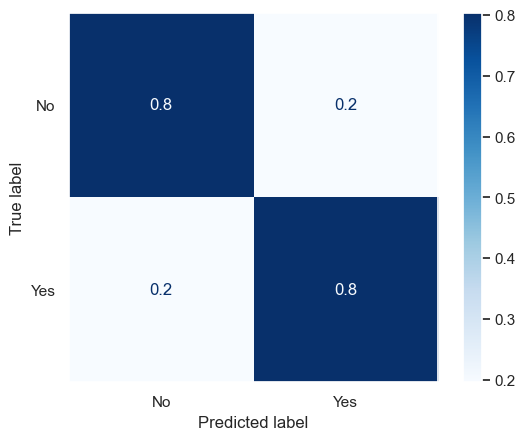

In [ ]:
# instantiate the LGBMClassifier model pipeline. Train with X_predict and predict over X_val
best_model_pipeline = create_pipeline_with_target_undersampling(LGBMClassifier(random_state=random_state))
best_model_pipeline.fit(X_train, y_train_encoded)
y_val_pred = best_model_pipeline.predict(X_val)

# validation set shape
print('\nval_set distribution:')
print(y_val.value_counts(), end='\n\n')

# ROC AUC score
roc_auc = roc_auc_score(y_val_encoded, best_model_pipeline.predict_proba(X_val)[:, 1])
print(f'Validation Set Metrics for LGBMClassifier baseline model:')
print(f'ROC AUC Score: {roc_auc:.4f}', end='\n\n')

# confusion matrix
conf_matrix = confusion_matrix(y_val_encoded, y_val_pred)
print('Confusion Matrix:')
print(conf_matrix, end='\n\n')

# Generate and display the classification report
print('Heart Attack Classification Report:')
print(classification_report(y_val_encoded, y_val_pred, target_names=['No', 'Yes']))

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_val_encoded, y_val_pred, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                       display_labels=['No', 'Yes']).plot(cmap='Blues');


## Hyperparameters Tuning

We will perform a fine-tuning of hyperparameters using GridSearchCV for the two best-performing models: LightGBM and CatBoost. 

This process will systematically explore a predefined set of hyperparameters and evaluate each combination based on cross-validation performance. The goal is to identify the optimal hyperparameter values that maximize model performance, particularly focusing on recall, and improve the model's ability to generalize to new, unseen data.

In [ ]:
# create pipeline for best models
models = {
    'LGBMClassifier': LGBMClassifier(random_state=random_state),
    'CatBoostClassifier': CatBoostClassifier(random_state=random_state)
}
pipelines = {name: create_pipeline_with_target_undersampling(model) for name, model in models.items()}

# grid parameters
param_grids_lightgbm = {
    'model__num_leaves': [31, 45, 60],
    'model__max_depth': [4, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [100, 200, 400],
    'model__min_child_samples': [20, 40],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

param_grids_catboost = {
    'model__iterations': [100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [4, 7, 10],
    'model__l2_leaf_reg': [1, 5, 7],
    'model__bagging_temperature': [0.0, 1.0, 5]
}

# i do stimate 40 mins to lightgbm, and 40-50 mins to catboost if fited in local machine
param_grids = {
    'LGBMClassifier': param_grids_lightgbm,
    'CatBoostClassifier': param_grids_catboost
}

# dictionary to storage best estimators
best_models = {}
results_list = []

# GridSearchCV kwargs
kwargs = {
    'cv': StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state),
    'scoring': 'recall',
    'n_jobs': -1,
    'verbose': 1 
}

for name, pipe in pipelines.items():
    print(f'Running GridSearchCV for {name}...')
    grid_search = GridSearchCV(estimator=pipe, 
                               param_grid=param_grids[name], 
                               **kwargs)
    time_init = time()
    grid_search.fit(X_train, y_train_encoded)
    fit_time = time() - time_init
    print(f'Fitting time: {fit_time} seconds.\n')
    
    # storage best estimator
    best_models[name] = grid_search.best_estimator_
    
    # storage training results
    results_list.append({
        'model': name,
        'best_score': grid_search.best_score_,
        'fit_time_sec': fit_time,
        'best_params': grid_search.best_params_
    })


Running GridSearchCV for LGBMClassifier...
Fitting 10 folds for each of 648 candidates, totalling 6480 fits
[LightGBM] [Info] Number of positive: 8598, number of negative: 8598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 17196, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fitting time: 2814.328946352005 seconds.

Running GridSearchCV for CatBoostClassifier...
Fitting 10 folds for each of 243 candidates, totalling 2430 fits
0:	learn: 0.6620388	total: 171ms	remaining: 16.9s
1:	learn: 0.6355753	total: 190ms	remaining: 9.3s
2:	learn: 0.6079136	total: 208ms	remaining: 6.73s
3:	learn: 0.5883292	total: 227ms	remaining: 5.44s
4:	learn: 0.5702554	total: 243ms	remain

In [23]:
# convert the results to a DataFrame for comparison
results_df = pd.DataFrame(results_list)
display(results_df)

,model,best_score,fit_time_sec,best_params
0,LGBMClassifier,0.803326,2814.328946,"{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 10, 'model__min_child_samples': 20, 'model__n_estimators': 100, 'model__num_leaves': 60, 'model__subsample': 0.8}"
1,CatBoostClassifier,0.797510,3227.195889,"{'model__bagging_temperature': 0.0, 'model__depth': 10, 'model__iterations': 100, 'model__l2_leaf_reg': 7, 'model__learning_rate': 0.1}"


The results have shown (sadly) only minimal improvement despite the considerable computational effort invested in hyperparameter tuning. 

Although the performance gains are slight, the models will still be saved for future reference using [pickle](https://docs.python.org/3/library/pickle.html). To ensure easy identification, **each model will be saved with the prefix "nb02," indicating they were generated within the notebook with the same prefix name**. This will help keep track of the development process and allow for easy comparison with other models or tuning efforts in subsequent analyses.

In [24]:
# save models to a pickle file
with open(f'../models/nb02_lgbm_model.pkl', 'wb') as file:
    pickle.dump(best_models['LGBMClassifier'], file)

with open(f'../models/nb02_cat_model.pkl', 'wb') as file:
    pickle.dump(best_models['CatBoostClassifier'], file)

Just as we can save models, we can also reload them when needed. This allows us to reuse the trained models without having to retrain them from scratch, saving both time and computational resources. 

The advantage of using the pipeline we've created becomes evident once we reload the saved models. The pipeline automates preprocessing steps, ensuring that any new data passed through it will receive the same transformations as the training data. This consistency is crucial for reliable predictions, as it prevents discrepancies that could arise if transformations were applied differently. 

Additionally, the pipeline simplifies the prediction process by combining multiple steps into a single, unified model, making it easy to apply to both training and production environments without additional adjustments.

In [25]:
# load the best model from a pickle file
with open('../models/nb02_lgbm_model.pkl', 'rb') as file:
    lgbm_model = pickle.load(file)
    
with open('../models/nb02_cat_model.pkl', 'rb') as file:
    cat_model = pickle.load(file)

## LGBMClassifier-tuned Validation

Now, we will perform a validation of the two models, LightGBM and CatBoost, to assess their performance on the validation set. This step will help confirm their effectiveness after fine-tuning and give a clear comparison of each model’s predictive accuracy, recall, and generalization capabilities on unseen data. 

By doing this, we can identify which model performs best for our specific classification task and make an informed choice for further development.

Validation Set Metrics for LGBMClassifier tuned:
ROC AUC Score: 0.8905

Confusion Matrix:
[[29465  7749]
 [  403  1747]]

Heart Attack Classification Report:
              precision    recall  f1-score   support

          No       0.99      0.79      0.88     37214
         Yes       0.18      0.81      0.30      2150

    accuracy                           0.79     39364
   macro avg       0.59      0.80      0.59     39364
weighted avg       0.94      0.79      0.85     39364



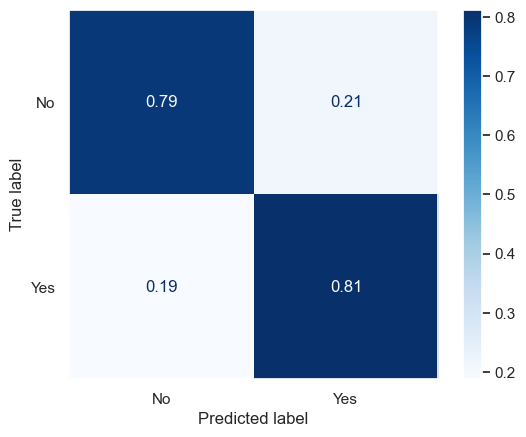

In [ ]:
# LGBMClassifier model pipeline. X_val predictions
y_val_pred = lgbm_model.predict(X_val)

# ROC AUC score
roc_auc = roc_auc_score(y_val_encoded, lgbm_model.predict_proba(X_val)[:, 1])
print(f'Validation Set Metrics for LGBMClassifier tuned:')
print(f'ROC AUC Score: {roc_auc:.4f}', end='\n\n')

# confusion matrix
conf_matrix = confusion_matrix(y_val_encoded, y_val_pred)
print('Confusion Matrix:')
print(conf_matrix, end='\n\n')

# Generate and display the classification report
print('Heart Attack Classification Report:')
print(classification_report(y_val_encoded, y_val_pred, target_names=['No', 'Yes']))

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_val_encoded, y_val_pred, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                       display_labels=['No', 'Yes']).plot(cmap='Blues');

## Catboost tuned validation

Validation Set Metrics for LGBMClassifier tuned:
ROC AUC Score: 0.8905

Confusion Matrix:
[[29922  7292]
 [  414  1736]]

Heart Attack Classification Report:
              precision    recall  f1-score   support

          No       0.99      0.80      0.89     37214
         Yes       0.19      0.81      0.31      2150

    accuracy                           0.80     39364
   macro avg       0.59      0.81      0.60     39364
weighted avg       0.94      0.80      0.85     39364



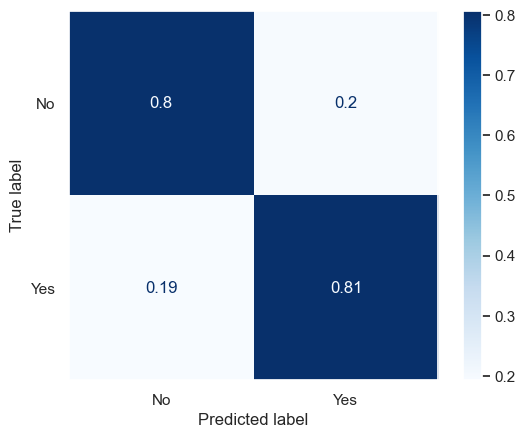

In [ ]:
# CatBoostClassifier model pipeline. X_val predictions
y_val_pred = cat_model.predict(X_val)

# ROC AUC score
roc_auc = roc_auc_score(y_val_encoded, lgbm_model.predict_proba(X_val)[:, 1])
print(f'Validation Set Metrics for LGBMClassifier tuned:')
print(f'ROC AUC Score: {roc_auc:.4f}', end='\n\n')

# confusion matrix
conf_matrix = confusion_matrix(y_val_encoded, y_val_pred)
print('Confusion Matrix:')
print(conf_matrix, end='\n\n')

# Generate and display the classification report
print('Heart Attack Classification Report:')
print(classification_report(y_val_encoded, y_val_pred, target_names=['No', 'Yes']))

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_val_encoded, y_val_pred, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                       display_labels=['No', 'Yes']).plot(cmap='Blues');

The next steps will involve improving the strengths of LightGBM and CatBoost, which can directly handle categorical features without requiring additional preprocessing like one-hot encoding. This feature simplifies the workflow by allowing us to pass categorical variables as they are, leading to more streamlined model training.

We will focus on building pipelines that retain only the selected features (both numerical and categorical), enabling efficient training and hyperparameter tuning with minimal data transformation. This approach not only makes the process more straightforward but also preserves the natural structure of the data, helping both models learn from it more effectively.

**In the following notebook, we will prioritize a more in-depth analysis of the prediction results**.